In [2]:
import numpy as np
import pandas as pd
from IPython.display import display, HTML, Image
from scipy.stats import ttest_ind_from_stats, spearmanr
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

# Reading Output

In [87]:
LEVEL2 = '/ais/gobi6/shirlywang/MIMIC/generalizing_ML_EMR/data/grouping_0/all_hourly_data.h5'
X_level2 = pd.read_hdf(LEVEL2, 'vitals_labs')
X_mean_level2 = pd.read_hdf(LEVEL2, 'vitals_labs_mean')
Y_level2 = pd.read_hdf(LEVEL2, 'interventions')
S_level2 = pd.read_hdf(LEVEL2, 'patients')

In [3]:
print(X_level2.shape)
print(X_mean_level2.shape)
print(Y_level2.shape)
print(S_level2.shape)

(2200954, 312)
(2200954, 104)
(2200954, 14)
(34472, 17)


In [5]:
ITEMID = '/ais/gobi6/shirlywang/MIMIC/generalizing_ML_EMR/data/nogrouping_0/all_hourly_data.h5'
X_itemid = pd.read_hdf(ITEMID, 'vitals_labs')
X_mean_itemid = pd.read_hdf(ITEMID, 'vitals_labs_mean')

In [5]:
print(X_itemid.shape)
print(X_mean_itemid.shape)

(2200954, 546)
(2200954, 182)


# Demographics

In [6]:
def categorize_age(age):
    if age > 10 and age <= 30: 
        cat = '<31'
    elif age > 30 and age <= 50:
        cat = '31-50'
    elif age > 50 and age <= 70:
        cat = '51-70'
    else: 
        cat = '>70'
    return cat
def categorize_ethnicity(ethnicity):
    if 'ASIAN' in ethnicity:
        ethnicity = 'ASIAN'
    elif 'WHITE' in ethnicity:
        ethnicity = 'WHITE'
    elif 'HISPANIC' in ethnicity:
        ethnicity = 'HISPANIC/LATINO'
    elif 'BLACK' in ethnicity:
        ethnicity = 'BLACK'
#    elif 'AMERICAN INDIAN' in ethnicity:
#        ethnicity = 'AMERICAN INDIAN'
    else: 
        ethnicity = 'OTHER'
    return ethnicity

In [7]:
S_level2['age_bucket'] = S_level2['age'].apply(categorize_age)
S_level2['ethnicity'] = S_level2['ethnicity'].apply(categorize_ethnicity)

In [9]:
S_level2

,,,gender,ethnicity,age,insurance,admittime,dischtime,deathtime,intime,outtime,los_icu,admission_type,first_careunit,mort_icu,mort_hosp,hospital_expire_flag,hospstay_seq,max_hours,age_bucket
subject_id,hadm_id,icustay_id,,,,,,,,,,,,,,,,,,
3,145834,211552,M,WHITE,76.5268,Medicare,2101-10-20 19:08:00,2101-10-31 13:58:00,NaT,2101-10-20 19:10:11,2101-10-26 20:43:09,6.0646,EMERGENCY,MICU,0,0,0,1,145,>70
4,185777,294638,F,WHITE,47.8450,Private,2191-03-16 00:28:00,2191-03-23 18:41:00,NaT,2191-03-16 00:29:31,2191-03-17 16:46:31,1.6785,EMERGENCY,MICU,0,0,0,1,40,31-50
6,107064,228232,F,WHITE,65.9407,Medicare,2175-05-30 07:15:00,2175-06-15 16:00:00,NaT,2175-05-30 21:30:54,2175-06-03 13:39:54,3.6729,ELECTIVE,SICU,0,0,0,1,88,51-70
9,150750,220597,M,OTHER,41.7902,Medicaid,2149-11-09 13:06:00,2149-11-14 10:15:00,2149-11-14 10:15:00,2149-11-09 13:07:02,2149-11-14 20:52:14,5.3231,EMERGENCY,MICU,1,1,1,1,127,31-50
11,194540,229441,F,WHITE,50.1483,Private,2178-04-16 06:18:00,2178-05-11 19:00:00,NaT,2178-04-16 06:19:32,2178-04-17 20:21:05,1.5844,EMERGENCY,SICU,0,0,0,1,38,51-70
12,112213,232669,M,WHITE,72.3724,Medicare,2104-08-07 10:15:00,2104-08-20 02:57:00,2104-08-20 02:57:00,2104-08-08 02:08:17,2104-08-15 17:22:25,7.6348,ELECTIVE,SICU,0,1,1,1,183,>70
13,143045,263738,F,WHITE,39.8661,Medicaid,2167-01-08 18:43:00,2167-01-15 15:15:00,NaT,2167-01-08 18:44:25,2167-01-12 10:43:31,3.6660,EMERGENCY,CCU,0,0,0,1,87,31-50
17,194023,277042,F,WHITE,47.4543,Private,2134-12-27 07:15:00,2134-12-31 16:05:00,NaT,2134-12-27 16:21:48,2134-12-29 18:04:03,2.0710,ELECTIVE,CSRU,0,0,0,1,49,31-50
18,188822,298129,M,WHITE,50.8416,Private,2167-10-02 11:18:00,2167-10-04 16:15:00,NaT,2167-10-02 11:20:39,2167-10-03 18:16:05,1.2885,EMERGENCY,CCU,0,0,0,1,30,51-70


In [10]:
by_ethnicity = S_level2.reset_index().pivot_table(index='ethnicity',
                                                  columns='gender',
                                                  values=['icustay_id','mort_icu','mort_hosp','max_hours'],
                                                  aggfunc={'icustay_id': 'count',
                                                           'mort_icu': 'mean',
                                                           'mort_hosp':'mean',
                                                          'max_hours':'mean'},
                                                  margins=True)
by_ethnicity = by_ethnicity.sort_values(by=('icustay_id','All'))
by_ethnicity = pd.concat([by_ethnicity], keys=['ethnicity'], names=['item'])

by_insurance = S_level2.reset_index().pivot_table(index='insurance',
                                                  columns='gender',
                                                  values=['icustay_id','mort_icu','mort_hosp','max_hours'],
                                                  aggfunc={'icustay_id': 'count',
                                                           'mort_icu': 'mean',
                                                           'mort_hosp':'mean',
                                                          'max_hours':'mean'},
                                                  margins=True)
by_insurance = by_insurance.sort_values(by=('icustay_id','All'))
by_insurance = pd.concat([by_insurance], keys=['insurance'], names=['item'])

by_age = S_level2.reset_index().pivot_table(index='age_bucket',
                                            columns='gender',
                                            values=['icustay_id','mort_icu','mort_hosp','max_hours'],
                                            aggfunc={'icustay_id': 'count',
                                                     'mort_icu': 'mean',
                                                     'mort_hosp':'mean',
                                                          'max_hours':'mean'},
                                            margins=True)
by_age = by_age.sort_values(by=('icustay_id','All'))
by_age = pd.concat([by_age], keys=['age'], names=['item'])

by_admission = S_level2.reset_index().pivot_table(index='admission_type',
                                                  columns='gender',
                                                  values=['icustay_id','mort_icu','mort_hosp','max_hours'],
                                                  aggfunc={'icustay_id': 'count',
                                                           'mort_icu': 'mean',
                                                           'mort_hosp':'mean',
                                                          'max_hours':'mean'},
                                                  margins=True)
by_admission = by_admission.sort_values(by=('icustay_id','All'))
by_admission = pd.concat([by_admission], keys=['admission_type'], names=['item'])

by_unit = S_level2.reset_index().pivot_table(index='first_careunit',
                                              columns='gender',
                                              values=['icustay_id','mort_icu','mort_hosp','max_hours'],
                                              aggfunc={'icustay_id': 'count',
                                                       'mort_icu': 'mean',
                                                       'mort_hosp':'mean',
                                                          'max_hours':'mean'},
                                              margins=True)
by_unit = by_unit.sort_values(by=('icustay_id','All'))
by_unit = pd.concat([by_unit], keys=['first_careunit'], names=['item'])

DataError: No numeric types to aggregate

In [ ]:
demographics = pd.concat([by_ethnicity, by_age, by_insurance, by_admission, by_unit],axis=0)
demographics.index.names = ['item','values']
demographics

## Histogram - age

Text(0,0.5,'count')

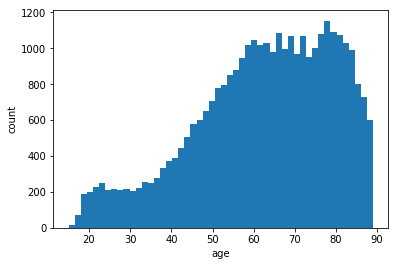

In [43]:
age = S_level2['age']
age = age[age<300]
plt.hist(age, bins=50)
plt.xlabel('age')
plt.ylabel('count')

## Histogram - los

Text(0,0.5,'count')

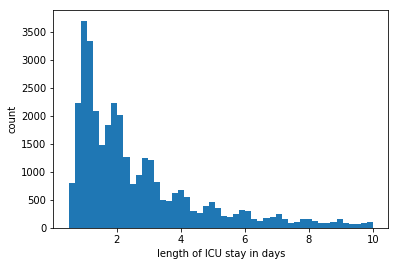

In [46]:
los = S_level2['los_icu']
plt.hist(los, bins=50)
plt.xlabel('length of ICU stay in days')
plt.ylabel('count')

In [39]:
age

array([76.5268, 47.845 , 65.9407, ..., 65.7722, 88.6983, 63.9803])

In [26]:
S_level2[S_level2['age']>300]

,,,gender,ethnicity,age,insurance,admittime,dischtime,deathtime,intime,outtime,los_icu,admission_type,first_careunit,mort_icu,mort_hosp,hospital_expire_flag,hospstay_seq,max_hours,age_bucket
subject_id,hadm_id,icustay_id,,,,,,,,,,,,,,,,,,
19,109235,273430,M,WHITE,300.0030,Medicare,2108-08-05 16:25:00,2108-08-11 11:29:00,NaT,2108-08-05 16:26:09,2108-08-06 23:40:35,1.3017,EMERGENCY,TSICU,0,0,0,1,31,>70
30,104557,225176,M,OTHER,300.0027,Medicare,2172-10-14 14:17:00,2172-10-19 14:37:00,NaT,2172-10-14 17:24:00,2172-10-16 13:44:00,1.8472,URGENT,CCU,0,0,0,1,44,>70
34,115799,263086,M,WHITE,300.0030,Medicare,2186-07-18 16:46:00,2186-07-20 16:00:00,NaT,2186-07-18 18:10:49,2186-07-19 11:27:20,0.7198,EMERGENCY,MICU,0,0,0,1,17,>70
56,181711,275642,F,WHITE,300.0013,Medicare,2104-01-02 02:01:00,2104-01-08 10:30:00,2104-01-08 10:30:00,2104-01-02 02:02:39,2104-01-03 22:25:29,1.8492,EMERGENCY,SICU,0,1,1,1,44,>70
112,174105,289222,M,WHITE,300.0032,Medicare,2194-06-13 18:39:00,2194-06-18 16:50:00,NaT,2194-06-13 18:41:27,2194-06-14 14:51:17,0.8402,EMERGENCY,MICU,0,0,0,1,20,>70
149,154869,224026,F,WHITE,300.0033,Medicare,2135-02-18 19:16:00,2135-02-26 17:00:00,NaT,2135-02-18 19:18:26,2135-02-21 11:45:46,2.6856,EMERGENCY,CCU,0,0,0,1,64,>70
151,151029,263211,F,BLACK,300.0034,Medicare,2145-05-06 20:00:00,2145-05-15 17:30:00,NaT,2145-05-07 14:08:39,2145-05-13 13:13:00,5.9614,EMERGENCY,CCU,0,0,0,1,143,>70
175,159223,279009,M,WHITE,300.0037,Medicare,2183-10-30 23:06:00,2183-11-11 13:25:00,NaT,2183-10-30 23:07:16,2183-11-01 20:38:54,1.8970,EMERGENCY,TSICU,0,0,0,1,45,>70
304,177469,295659,F,BLACK,300.0031,Medicaid,2141-05-18 17:21:00,2141-05-19 01:45:00,2141-05-19 01:45:00,2141-05-18 17:22:10,2141-05-19 05:40:47,0.5129,EMERGENCY,CCU,1,1,1,1,12,>70


In [ ]:
S_level

In [16]:
age

NameError: name 'age' is not defined

# Vitals and Labs

In [11]:
vitals_mean = pd.DataFrame(X_mean_level2.mean(),columns=['mean'])
vitals_std = pd.DataFrame(X_mean_level2.std(),columns=['stdev'])
vitals_missing = pd.DataFrame(X_mean_level2.isna().sum()/X_mean_level2.shape[0]*100,columns=['missing percent'])

vitals_summary = pd.concat([vitals_mean,vitals_std,vitals_missing],axis=1)
vitals_summary.index = vitals_summary.index.droplevel(1)
vitals_summary.sort_values(by='missing percent',ascending=True,inplace=True)
vitals_summary

,mean,stdev,missing percent
LEVEL2,,,
heart rate,84.974313,17.271791,10.413939
respiratory rate,19.093328,5.722042,11.835777
systolic blood pressure,121.828655,21.994139,13.258342
diastolic blood pressure,60.891112,14.128354,13.279696
mean blood pressure,79.371499,15.486783,13.712145
oxygen saturation,96.726713,3.591092,14.384808
temperature,36.978373,0.784002,70.541956
glucose,140.489701,57.220265,76.710781
central venous pressure,11.578607,16.097323,80.352247


In [13]:
vitals_summary.to_csv('../resources/level2_stat.csv')

In [12]:
vitals_mean_itemid = pd.DataFrame(X_mean_itemid.mean(),columns=['mean'])
vitals_std_itemid = pd.DataFrame(X_mean_itemid.std(),columns=['stdev'])
vitals_missing_itemid = pd.DataFrame(X_mean_itemid.isna().sum()/X_mean_level2.shape[0]*100,columns=['missing percent'])

vitals_summary_itemid = pd.concat([vitals_mean_itemid,vitals_std_itemid,vitals_missing_itemid],axis=1)
vitals_summary_itemid.index = vitals_summary_itemid.index.droplevel(4)
vitals_summary_itemid.sort_values(by='missing percent',ascending=True,inplace=True)
vitals_summary_itemid

,,,,mean,stdev,missing percent
itemid,label,LEVEL1,LEVEL2,,,
211,heart rate,heart rate,heart rate,85.117205,17.145789,48.415823
618,respiratory rate,respiratory rate,respiratory rate,19.356591,5.721490,49.914582
646,spo2,pulse oximetry,oxygen saturation,97.010374,3.453388,51.633746
220045,heart rate,heart rate,heart rate,84.779794,17.439690,61.995480
220210,respiratory rate,respiratory rate,respiratory rate,19.248841,5.520934,62.255049
220277,o2 saturation pulseoxymetry,pulse oximetry,oxygen saturation,96.673042,3.184367,63.025079
455,nbp [systolic],systolic blood pressure (noninvasive),systolic blood pressure,121.230398,22.036007,71.978378
8441,nbp [diastolic],diastolic blood pressure (noninvasive),diastolic blood pressure,59.003108,14.830207,72.004231
456,nbp mean,mean blood pressure (noninvasive),mean blood pressure,78.274848,14.700985,72.431228


In [14]:
vitals_summary_itemid.to_csv('../resources/item_id_stat.csv')

In [3]:
source = pd.read_csv('../resources/itemid_to_variable_map.csv')
source.head()

,LEVEL2,LEVEL1,ALTERNATIVE,STATUS,STATUS NOTE,ITEMID,MIMIC LABEL,UNITNAME,LINKSTO,COUNT,CATEGORY,CONCEPTID,FLUID,LOINC_CODE,DBSOURCE,Unnamed: 15,PARAM_TYPE,NOTE
0,Alanine aminotransferase,Alanine aminotransferase,ALT,ready,NaN,50861,ALANINE AMINOTRANSFERASE (ALT),NaN,labevents,219475.0,CHEMISTRY,NaN,BLOOD,6/1/1742,NaN,NaN,NaN,NaN
1,Alanine aminotransferase,Alanine aminotransferase,ALT,ready,NaN,769,ALT,NaN,chartevents,41594.0,Enzymes,NaN,NaN,NaN,carevue,NaN,NaN,NaN
2,Alanine aminotransferase,Alanine aminotransferase,ALT,ready,NaN,220644,ALT,None,chartevents,37625.0,Labs,NaN,NaN,NaN,metavision,NaN,Numeric,NaN
3,Albumin,Albumin,NaN,ready,NaN,50862,ALBUMIN,NaN,labevents,146697.0,CHEMISTRY,NaN,BLOOD,7/1/1751,NaN,NaN,NaN,NaN
4,Albumin,Albumin,NaN,ready,NaN,772,Albumin (>3.2),NaN,chartevents,31022.0,Chemistry,NaN,NaN,NaN,carevue,NaN,NaN,NaN


In [8]:
source = source.set_index('ITEMID')
source_dict = source['DBSOURCE'].to_dict()

In [6]:
X_mean_itemid.head()

itemid                                                                 51  \
label                                              arterial bp [systolic]   
LEVEL1                                 systolic blood pressure (arterial)   
LEVEL2                                            systolic blood pressure   
Aggregation Function                                                 mean   
subject_id hadm_id icustay_id hours_in                                      
3          145834  211552     0                                     39.00   
                              1                                     77.75   
                              2                                     91.00   
                              3                                    117.00   
                              4                                    102.00   

itemid                                                             52  \
label                                                arterial bp mean   
LEVEL1                                 mean blood pressure (arterial)   
LEVEL2                                            mean blood pressure   
Aggregation Function                                             mean   
subject_id hadm_id icustay_id hours_in                                  
3          145834  211552     0                                159.50   
                              1                                 60.25   
                              2                                 71.00   
                              3                                 84.75   
                              4                                 77.00   

itemid                                                  89  \
label                                          c.o. (fick)   
LEVEL1                                 cardiac output fick   
LEVEL2                                 cardiac output fick   
Aggregation Function                                  mean   
subject_id hadm_id icustay_id hours_in                       
3          145834  211552     0                        NaN   
                              1                        NaN   
                              2                        NaN   
                              3                        NaN   
                              4                        NaN   

itemid                                                            90  \
label                                           c.o.(thermodilution)   
LEVEL1                                 cardiac output thermodilution   
LEVEL2                                 cardiac output thermodilution   
Aggregation Function                                            mean   
subject_id hadm_id icustay_id hours_in                                 
3          145834  211552     0                                  NaN   
                              1                                  NaN   
                              2                                  NaN   
                              3                                  NaN   
                              4                                  NaN   

itemid                                                     113           116  \
label                                                      cvp cardiac index   
LEVEL1                                 central venous pressure cardiac index   
LEVEL2                                 central venous pressure cardiac index   
Aggregation Function                                      mean          mean   
subject_id hadm_id icustay_id hours_in                                         
3          145834  211552     0                            NaN           NaN   
                              1                            NaN           NaN   
                              2                            NaN           NaN   
                              3                           13.0           NaN   
                              4                           16.0          

In [21]:
source[source['DBSOURCE']=='carevue'].index.values

array([  769,   772,  1521, ..., 40651, 40715, 43175])

In [23]:
carevue_id = list(source[source['DBSOURCE']=='carevue'].index.values)
nan_id = list(source[source['DBSOURCE'].isnull()].index.values)
metavision_id = list(source[source['DBSOURCE']=='metavision'].index.values)

In [24]:
carevue_id = carevue_id + nan_id
metavision_id = metavision_id + nan_id

In [34]:
len(carevue_id)

9813

In [27]:
idx = pd.IndexSlice
X_mean_carevue = X_mean_itemid.loc[:,idx[carevue_id,:]]

In [40]:
X_mean.head()

itemid                                      51      52  89  90   113  116  \
subject_id hadm_id icustay_id hours_in                                      
3          145834  211552     0          39.00  159.50 NaN NaN   NaN  NaN   
                              1          77.75   60.25 NaN NaN   NaN  NaN   
                              2          91.00   71.00 NaN NaN   NaN  NaN   
                              3         117.00   84.75 NaN NaN  13.0  NaN   
                              4         102.00   77.00 NaN NaN  16.0  NaN   

itemid                                  189  190  198     211  ...  227429  \
subject_id hadm_id icustay_id hours_in                         ...           
3          145834  211552     0         NaN  1.0  NaN  143.00  ...     NaN   
                              1         NaN  NaN  NaN  153.75  ...     NaN   
                              2         NaN  NaN  NaN  137.75  ...     NaN   
                              3         NaN  NaN  NaN  129.25  ...     NaN   
                              4         NaN  0.8  NaN  146.00  ...     NaN   

itemid                                  227442  227443  227456  227457  \
subject_id hadm_id icustay_id hours_in                                   
3          145834  211552     0            NaN     NaN     NaN     NaN   
                              1            NaN     NaN     NaN     NaN   
                              2            NaN     NaN     NaN     NaN   
                              3            NaN     NaN     NaN     NaN   
                              4            NaN     NaN     NaN     NaN   

itemid                                  227464  227465  227466  227467  227468  
subject_id hadm_id icustay_id hours_in                                          
3          145834  211552     0            NaN     NaN     NaN     NaN     NaN  
                              1            NaN     NaN     NaN     NaN     NaN  
                              2            NaN     NaN     NaN     NaN     NaN  
                              3            NaN     NaN     NaN     NaN     NaN  
                              4            NaN     NaN     NaN     NaN     NaN  

[5 rows x 182 columns]

In [72]:
X_mask = X_mean.copy()
for i in X_mask.columns:
    if int(i) >= 50000 and int(i) <= 59000:
        X_mask.loc[:,i] = np.NaN
    elif int(i) > 100000:
        X_mask.loc[:,i] = np.where(X_mask.loc[:,i].isnull(),np.NaN,1)
    else:
        X_mask.loc[:,i] = np.where(X_mask.loc[:,i].isnull(),np.NaN,-1)

In [73]:
idx_source = pd.DataFrame(X_mask.sum(axis=1))

In [74]:
idx_meta = idx_source[idx_source.loc[:,0]>-1]
idx_care = idx_source[idx_source.loc[:,0]<1]

In [83]:
idx_meta

0
subject_id hadm_id icustay_id hours_in      
3          145834  211552     142        0.0
                              143        0.0
                              144        0.0
                              145        0.0
4          185777  294638     0          0.0
                              26         0.0
                              30         0.0
                              32         0.0
                              34         0.0
                              36         0.0
                              38         0.0
                              39         0.0
                              40         0.0
6          107064  228232     12         0.0
                              43         0.0
                              87         0.0
                              88         0.0
9          150750  220597     121        0.0
                              122        0.0
                              123        0.0
                              124        0.0
                              125        0.0
                              126        0.0
                              127        0.0
11         194540  229441     29         0.0
                              30         0.0
                              35         0.0
                              37         0.0
                              38         0.0
12         112213  232669     175        0.0
...                                      ...
99995      137810  229633     49         6.0
                              50         2.0
                              51         6.0
99999      113369  246512     0         12.0
                              1          6.0
                              2          7.0
                              3          6.0
                              4          9.0
                              5          7.0
                              6          6.0
                              7          6.0
                              8          7.0
                              9          6.0
                              10         7.0
                              11         6.0
                              12         6.0
                              13         6.0
                              14         6.0
                              15         6.0
                              16         6.0
                              17        23.0
                              18         6.0
                              19         6.0
                              20         7.0
                              21         6.0
                              22         7.0
                              23         6.0
                              24         7.0
                              25         6.0
                              26         0.0

[1040259 rows x 1 columns]

In [92]:
X_mean_level2.columns = X_mean_level2.columns.droplevel(1)

In [93]:
X_mean_carevue_level2 = X_mean_level2.merge(idx_care, right_index=True, left_index=True, how='right')
X_mean_metavision_level2 = X_mean_level2.merge(idx_meta, right_index=True, left_index=True, how='right')

In [95]:
X_mean_carevue_level2.shape

(1343019, 105)

In [96]:
carevue_missing_level2 = pd.DataFrame(X_mean_carevue_level2.isna().sum()/X_mean_carevue_level2.shape[0]*100,
                                      columns=['missing percent_carevue'])
metavision_missing_level2 = pd.DataFrame(X_mean_metavision_level2.isna().sum()/X_mean_metavision_level2.shape[0]*100,
                                      columns=['missing percent_metavision'])
missing_level2 = pd.concat([carevue_missing_level2,metavision_missing_level2],axis=1)

In [97]:
missing_level2.to_csv('../resources/missing_level2_by_source.csv')

In [98]:
missing_level2

,missing percent_carevue,missing percent_metavision
alanine aminotransferase,98.494213,97.513215
albumin,98.910514,98.483743
albumin ascites,99.995235,99.993944
albumin pleural,99.993299,99.993271
albumin urine,99.993969,99.994713
alkaline phosphate,98.540527,97.572431
anion gap,93.631885,89.852623
asparate aminotransferase,98.493916,97.509851
basophils,99.125254,98.955452
bicarbonate,93.156389,89.533472


In [76]:
X_mean_carevue.shape

(1343019, 183)

In [81]:
carevue_missing_itemid = pd.DataFrame(X_mean_carevue.isna().sum()/X_mean_carevue.shape[0]*100,
                                      columns=['missing percent_carevue'])
metavision_missing_itemid = pd.DataFrame(X_mean_metavision.isna().sum()/X_mean_metavision.shape[0]*100,
                                      columns=['missing percent_metavision'])
missing_itemid = pd.concat([carevue_missing_itemid,metavision_missing_itemid],axis=1)

In [86]:
missing_itemid.to_csv('../resources/missing_itemid_by_source.csv')

In [77]:
X_mean_metavision.shape

(1040259, 183)

In [71]:
X_mean.shape

(2200954, 182)

In [59]:
idx_meta.shape

(2200954, 1)

In [30]:
X_mean = X_mean_itemid.copy()
X_mean.columns = X_mean.columns.droplevel([1,2,3,4])
X_mean[carevue_id]

KeyError: u"None of [Int64Index([  769,   772,  1521,  3727,   773,  3728,  3732,   770,   803,\n             1538,\n            ...\n            51545, 51546, 51547, 51548, 51549, 51550, 51551, 51552, 51553,\n            51554],\n           dtype='int64', name=u'itemid', length=9813)] are in the [columns]"

## Interventions

In [195]:
mean_duration = pd.DataFrame(Y_level2.reset_index().groupby('icustay_id').agg(sum).mean()[3:],columns=['hours'])

In [196]:
# average duration of each intervention given for one icu stay 
# (colloid bolus, crystalloid bolus - number of times given)
mean_duration

,hours
vent,12.201178
vaso,8.099124
adenosine,0.001508
dobutamine,0.356782
dopamine,0.948364
epinephrine,0.598399
isuprel,0.005483
milrinone,0.871838
norepinephrine,2.720933
phenylephrine,4.055697


In [16]:
S_level2.isna().sum()

gender                      0
ethnicity                   0
age                         0
insurance                   0
admittime                   0
dischtime                   0
deathtime               31122
intime                      0
outtime                     0
los_icu                     0
admission_type              0
first_careunit              0
mort_icu                    0
mort_hosp                   0
hospital_expire_flag        0
hospstay_seq                0
max_hours                   0
age_bucket                  0
dtype: int64